# Algorytm

C: 2025.02.10 <br>
M: 2025.02.10


Copyright (c) 2025 Marek Kocinski


In [4]:
import cv2
from pyzbar.pyzbar import decode
from pyzbar import pyzbar
import numpy as np
from typing import Optional, Tuple, List
from pathlib import Path
import matplotlib.pyplot as plt


In [51]:

class BarcodeProcessor:
    def __init__(self):
        # Słownik prefixów kodów EAN
        self.ean_country_codes = {
            '00-13': 'USA/Canada',
            '20-29': 'In-store numbers',
            '30-37': 'France',
            '40-44': 'Germany',
            '45-49': 'Japan',
            '50': 'UK',
            '57': 'Denmark',
            '59': 'Poland',
            '70': 'Norway',
            '73': 'Sweden',
            '76': 'Switzerland',
            # można dodać więcej kodów krajów
        }

    def preprocess_for_barcode(self, image: np.ndarray) -> np.ndarray:
        """
        Przygotowuje obraz do lepszego rozpoznawania kodów kreskowych
        """
        # Konwersja do skali szarości
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Redukcja szumu
        denoised = cv2.fastNlMeansDenoising(gray)
        
        # Adaptacyjna binaryzacja
        binary = cv2.adaptiveThreshold(
            denoised, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 
            11, 
            2
        )
        
        # Dodatkowe operacje morfologiczne dla poprawy czytelności kodu
        kernel = np.ones((3,3), np.uint8)
        morphed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        return morphed

    def detect_barcode_area(self, image: np.ndarray) -> Optional[Tuple[int, int, int, int]]:
        """
        Wykrywa obszar, gdzie znajduje się kod kreskowy
        Zwraca koordynaty (x, y, w, h) lub None
        """
        # Konwersja do skali szarości jeśli obraz jest kolorowy
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Zastosowanie rozmycia gaussowskiego aby zredukować szum
        blurred = cv2.GaussianBlur(gray, (9, 9), 0)
        
        # Wykrywanie krawędzi z lepszymi parametrami
        edges = cv2.Canny(blurred, 50, 200)
        
        # Operacje morfologiczne aby połączyć krawędzie
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
        closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        
        # Znajdowanie konturów
        contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Sortowanie konturów po obszarze (największe pierwsze)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        
        for contour in contours:
            # Minimalna wielkość konturu
            if cv2.contourArea(contour) < 1000:
                continue
                
            # Obliczanie prostokąta ograniczającego
            x, y, w, h = cv2.boundingRect(contour)
            
            # Sprawdzanie proporcji (kody kreskowe są zwykle szersze niż wyższe)
            aspect_ratio = w / float(h)
            if 2.0 < aspect_ratio < 5.0:
                return (x, y, w, h)
        
        return None

    def validate_ean13(self, barcode: str) -> bool:
        """
        Walidacja kodu EAN-13
        """
        if not barcode or len(barcode) != 13 or not barcode.isdigit():
            return False
        
        # Obliczanie cyfry kontrolnej
        total = 0
        for i in range(12):
            if i % 2 == 0:
                total += int(barcode[i])
            else:
                total += int(barcode[i]) * 3
                
        check_digit = (10 - (total % 10)) % 10
        return check_digit == int(barcode[-1])

    def get_country_of_origin(self, barcode: str) -> Optional[str]:
        """
        Określa kraj pochodzenia na podstawie prefiksu EAN
        """
        if not barcode or len(barcode) < 3:
            return None
            
        prefix = barcode[:2]
        for code_range, country in self.ean_country_codes.items():
            if '-' in code_range:
                start, end = code_range.split('-')
                if int(prefix) >= int(start) and int(prefix) <= int(end):
                    return country
            elif prefix.startswith(code_range):
                return country
                
        return None

    def read_barcode(self, image: np.ndarray) -> List[dict]:
        """
        Główna funkcja do odczytu i analizy kodów kreskowych
        """
        results = []

        print(image.shape)

        try:
            print('Algorithm started')
            # Konwersja do skali szarości jeśli obraz jest kolorowy
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image

            # Preprocesssing obrazu - kilka różnych wersji
            # 1. Standardowy preprocessing
            processed1 = self.preprocess_for_barcode(gray)
            
            # 2. Wersja z adaptacyjnym progowaniem
            processed2 = cv2.adaptiveThreshold(
                gray, 255, 
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                cv2.THRESH_BINARY, 11, 2
            )
            
            # 3. Wersja z prostym progowaniem
            _, processed3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Lista wszystkich przetworzonych wersji
            processed_versions = [gray, processed1, processed2, processed3]

            # Próbujemy każdą wersję preprocessingu
            for processed in processed_versions:
                # Próba wykrycia obszaru kodu kreskowego
                barcode_area = self.detect_barcode_area(processed)
                if barcode_area:
                    x, y, w, h = barcode_area
                    roi = processed[y:y+h, x:x+w]
                    
                    # Próba dekodowania na wyciętym obszarze
                    barcodes = decode(roi)
                    if barcodes:
                        for barcode in barcodes:
                            try:
                                barcode_data = barcode.data.decode('utf-8')
                                barcode_type = barcode.type
                                
                                result = {
                                    'barcode': barcode_data,
                                    'type': barcode_type,
                                    'valid': False,
                                    'country_of_origin': None,
                                    'rect': barcode_area  # dodajemy informację o położeniu
                                }
                                
                                # Walidacja w zależności od typu kodu
                                if barcode_type == 'EAN13':
                                    result['valid'] = self.validate_ean13(barcode_data)
                                    result['country_of_origin'] = self.get_country_of_origin(barcode_data)
                                
                                results.append(result)
                            except Exception as e:
                                print(f"Error processing barcode: {str(e)}")
                                continue

                # Jeśli nie znaleźliśmy kodów w wyciętym obszarze,
                # spróbujmy na całym obrazie
                if not results:
                    barcodes = decode(processed)
                    if barcodes:
                        for barcode in barcodes:
                            try:
                                barcode_data = barcode.data.decode('utf-8')
                                barcode_type = barcode.type
                                
                                result = {
                                    'barcode': barcode_data,
                                    'type': barcode_type,
                                    'valid': False,
                                    'country_of_origin': None
                                }
                                
                                if barcode_type == 'EAN13':
                                    result['valid'] = self.validate_ean13(barcode_data)
                                    result['country_of_origin'] = self.get_country_of_origin(barcode_data)
                                
                                results.append(result)
                            except Exception as e:
                                print(f"Error processing barcode: {str(e)}")
                                continue

                # Jeśli znaleźliśmy jakieś kody, przerywamy pętlę
                if results:
                    break

        except Exception as e:
            print(f"Error in read_barcode: {str(e)}")

        # Na początku funkcji:
        print(f"Image shape: {image.shape}")
        print(f"Image type: {image.dtype}")
        cv2.imwrite("debug_original.jpg", image)
        cv2.imwrite("debug_processed1.jpg", processed1)
        cv2.imwrite("debug_processed2.jpg", processed2)
        cv2.imwrite("debug_processed3.jpg", processed3)

        return results

    def save_barcode_image(self, image: np.ndarray, barcode_data: dict, output_path: str):
        """
        Zapisuje obraz z zaznaczonym kodem kreskowym
        """
        # Kopiowanie obrazu do oznaczenia
        marked_image = image.copy()
        
        # Zaznaczanie obszaru kodu kreskowego
        if 'rect' in barcode_data:
            x, y, w, h = barcode_data['rect']
            cv2.rectangle(marked_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # Dodawanie tekstu z danymi
            text = f"Code: {barcode_data['barcode']}"
            cv2.putText(marked_image, text, (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
        cv2.imwrite(output_path, marked_image)

In [45]:
current_dir = Path.cwd()
imgs_pth = current_dir.parent / 'produkty'
imgs = list(imgs_pth.glob("*.JPEG"))
print(len(imgs))
print(imgs[0])

17
/home/marek/biblioteka-repozytoriow-git/biblioteka-kodow-git/technologie/json-vault/produkty/IMG_4389.JPEG


In [46]:
img = imgs[0]
plt.show(img)
plt.show()

In [26]:

def show_image(image, title="Image", cmap=plt.cm.gray):
    plt.figure(figsize=(10,8))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

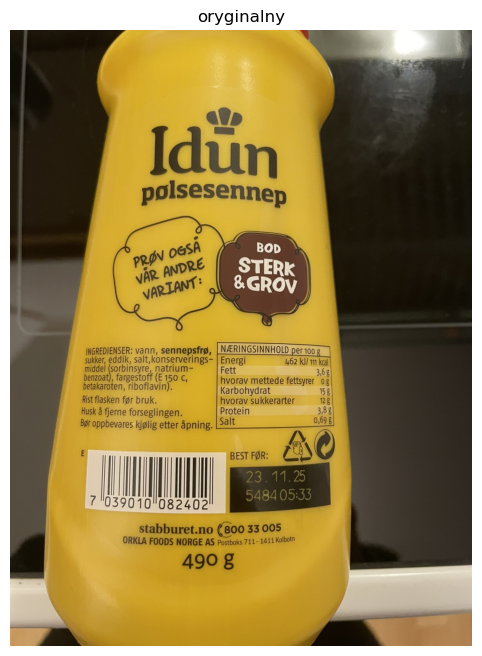

(2048, 1536, 3)


In [27]:
img_pth = imgs[0]
img = plt.imread(img_pth)
show_image(img, "oryginalny", "gray")
print(img.shape)

In [34]:
processor = BarcodeProcessor()

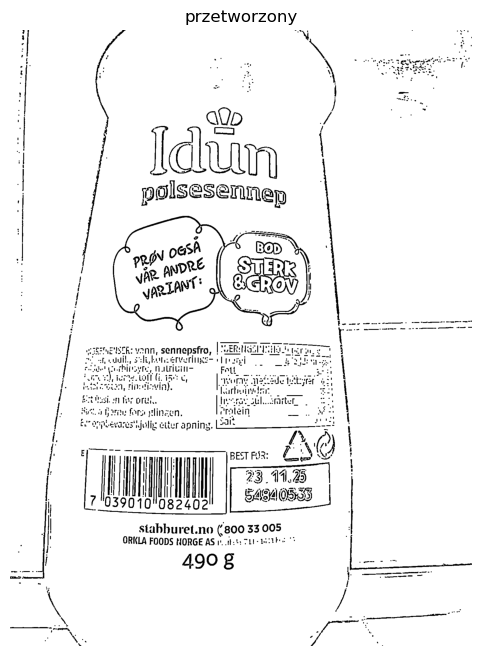

In [37]:
# 1. Wczytaj obraz (używając cv2)
image = cv2.imread(img_pth)

# 2. Przetwórz obraz
processed_image = processor.preprocess_for_barcode(image)
# Zwraca: przetworzony obraz (np.ndarray)
show_image(processed_image, "przetworzony", "gray")

In [41]:

# 3. Wykryj obszar kodu (opcjonalne)
barcode_area = processor.detect_barcode_area(processed_image)
# Zwraca: (x, y, w, h) lub None
print(barcode_area)


(142, 1988, 14, 6)


In [54]:
# 4. Odczytaj kod kreskowy
results = processor.read_barcode(image)  # można użyć oryginalnego obrazu
# Zwraca: lista słowników z informacjami o kodach
print(results)


[]


In [ ]:
# 5. Zapisz wynik (opcjonalne)
processor.save_barcode_image(image, results[0], "output.jpg")